In [1]:
import os

import dolfinx
import gmsh
import matplotlib.pyplot as plt
import meshio
import numpy as np
import pyvista
import pyvista as pv
import pyvistaqt as pvqt
import ufl
import warnings

from dolfinx import cpp, default_scalar_type, fem, io, mesh, nls, plot
from dolfinx.fem import petsc
from dolfinx.io import VTXWriter
from dolfinx.nls import petsc as petsc_nls
from dolfinx.geometry import bb_tree, compute_collisions_points, compute_colliding_cells
from mpi4py import MPI
from petsc4py import PETSc
from ufl import (Circumradius, FacetNormal, SpatialCoordinate, TrialFunction, TestFunction,
                 dot, div, dx, ds, dS, grad, inner, grad, avg, jump)

import commons, configs, geometry, utils

warnings.simplefilter('ignore')

In [2]:
run_mesh = True
adaptive_refine = True
micron = 1e-6
resolution = 1 * micron

L_sep = 25 * micron
L_neg_cc = 20 * micron
L_sep_neg_cc = 15 * micron
feature_radius = 5 * micron
disk_radius = 100 * micron
L_total = L_sep + L_neg_cc

In [3]:
comm = MPI.COMM_WORLD
encoding = io.XDMFFile.Encoding.HDF5
name_of_study = "lithium_metal_3d_cc_2d"
dimensions = '100-100-45'
workdir = os.path.join(configs.get_configs()['LOCAL_PATHS']['data_dir'], name_of_study, dimensions, str(resolution))
utils.make_dir_if_missing(workdir)
output_meshfile = os.path.join(workdir, 'mesh.msh')
tetr_meshfile = os.path.join(workdir, "tetr.xdmf")
tria_meshfile = os.path.join(workdir, "tria.xdmf")
line_meshfile = os.path.join(workdir, "line.xdmf")
potential_resultsfile = os.path.join(workdir, "potential.bp")
potential_dg_resultsfile = os.path.join(workdir, "potential_dg.bp")
concentration_resultsfile = os.path.join(workdir, "concentration.bp")
current_resultsfile = os.path.join(workdir, "current.bp")

In [4]:
markers = commons.Markers()

### Mesh for 2D

In [5]:
points = [
    (0, 0, 0),
    # (5 * micron, 0, 0),
    (20 * micron, 0, 0),
    (45 * micron, 0, 0),
    (45 * micron, 30 * micron, 0),
    (20 * micron, 30 * micron, 0),
    (0, 30 * micron, 0),
    # middle
    (20 * micron, 20 * micron, 0),
    (5 * micron, 20 * micron, 0),
    (5 * micron, 10 * micron, 0),
    (20 * micron, 10 * micron, 0),
]
gpoints = []
lines = []

gmsh.initialize()
gmsh.model.add('lithium-metal')
# gmsh.option.setNumber("Mesh.CharacteristicLengthMin", 0.25*micron)
gmsh.option.setNumber("Mesh.CharacteristicLengthMax", 1*micron)

for idx, p in enumerate(points):
    gpoints.append(
        gmsh.model.occ.addPoint(*p)
    )
gmsh.model.occ.synchronize()

for idx in range(5):
    lines.append(
        gmsh.model.occ.addLine(gpoints[idx], gpoints[idx+1])
    )
lines.append(
    gmsh.model.occ.addLine(gpoints[5], gpoints[0])
)
lines.append(
    gmsh.model.occ.addLine(gpoints[4], gpoints[6])
)
lines.append(
    gmsh.model.occ.addLine(gpoints[6], gpoints[7])
)
lines.append(
    gmsh.model.occ.addLine(gpoints[7], gpoints[8])
)
lines.append(
    gmsh.model.occ.addLine(gpoints[8], gpoints[9])
)
lines.append(
    gmsh.model.occ.addLine(gpoints[9], gpoints[1])
)
insulated = [lines[idx] for idx in [0, 4, 1, 3]]
gmsh.model.occ.synchronize()
gmsh.model.addPhysicalGroup(1, [lines[5]], markers.left)
gmsh.model.addPhysicalGroup(1, [lines[2]], markers.right)
gmsh.model.addPhysicalGroup(1, [lines[idx] for idx in range(6, 11)], markers.negative_cc_v_negative_am)
gmsh.model.addPhysicalGroup(1, [lines[idx] for idx in [0, 4]], markers.insulated_negative_cc)
gmsh.model.addPhysicalGroup(1, [lines[idx] for idx in [1, 3]], markers.insulated_electrolyte)
gmsh.model.addP
gmsh.model.occ.synchronize()
se_loop = gmsh.model.occ.addCurveLoop([lines[idx] for idx in [1, 2, 3, 6, 7, 8, 9, 10]])
ncc_loop = gmsh.model.occ.addCurveLoop([lines[idx] for idx in [0, 5, 4, 6, 7, 8, 9, 10]])
gmsh.model.occ.synchronize()
se_phase = gmsh.model.occ.addPlaneSurface([se_loop])
ncc_phase = gmsh.model.occ.addPlaneSurface([ncc_loop])
gmsh.model.occ.synchronize()
gmsh.model.addPhysicalGroup(2, [se_phase], markers.electrolyte)
gmsh.model.addPhysicalGroup(2, [ncc_phase], markers.negative_cc)
gmsh.model.occ.synchronize()

# gmsh.model.occ.dilate(gmsh.model.get_entities(1), 0, 0, 0, micron, micron, micron)
gmsh.model.occ.synchronize()
# adaptive refinement
gmsh.model.mesh.generate(2)
gmsh.write(output_meshfile)
gmsh.finalize()

mesh_2d = meshio.read(output_meshfile)
tria_mesh = geometry.create_mesh(mesh_2d, "triangle")
meshio.write(tria_meshfile, tria_mesh)
line_mesh = geometry.create_mesh(mesh_2d, "line")
meshio.write(line_meshfile, line_mesh)

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 20%] Meshing curve 3 (Line)
Info    : [ 30%] Meshing curve 4 (Line)
Info    : [ 40%] Meshing curve 5 (Line)
Info    : [ 50%] Meshing curve 6 (Line)
Info    : [ 60%] Meshing curve 7 (Line)
Info    : [ 70%] Meshing curve 8 (Line)
Info    : [ 80%] Meshing curve 9 (Line)
Info    : [ 90%] Meshing curve 10 (Line)
Info    : [100%] Meshing curve 11 (Line)
Info    : Done meshing 1D (Wall 0.000514789s, CPU 0.000443s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : [ 50%] Meshing surface 2 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0409182s, CPU 0.040585s)
Info    : 1690 nodes 3448 elements
Info    : Writing 'output/lithium_metal_3d_cc_2d/100-100-45/1e-06/mesh.msh'...
Info    : Done writing 'output/lithium_metal_3d_cc_2d/100-100-45/1e-06/mesh.msh'



## Binary Electrolyte - Nernst-Planck Equation

We make the following assumptions
- no bulk flow
- diffusivity not a function of concentration
- binary electrolyte

$$\frac{\partial c}{\partial t} + \pmb{v}\cdot\nabla c - D\nabla^2c=0$$

#### read input mesh and generate tags

In [6]:
with io.XDMFFile(comm, tria_meshfile, "r") as infile3:
    domain = infile3.read_mesh(cpp.mesh.GhostMode.none, 'Grid')
    ct = infile3.read_meshtags(domain, name="Grid")
tdim = domain.topology.dim
fdim = tdim - 1
domain.topology.create_connectivity(tdim, fdim)

ft_imap = domain.topology.index_map(fdim)
num_facets = ft_imap.size_local + ft_imap.num_ghosts
indices = np.arange(0, num_facets)
values = np.zeros(indices.shape, dtype=np.intc)  # all facets are tagged with zero

with io.XDMFFile(comm, line_meshfile, "r") as infile2:
    ft = infile2.read_meshtags(domain, name="Grid")

values[ft.indices] = ft.values
meshtags = mesh.meshtags(domain, fdim, indices, values)
domaintags = mesh.meshtags(domain, domain.topology.dim, ct.indices, ct.values)

## Solve Potential Problem

In [7]:
dx = ufl.Measure("dx", domain=domain, subdomain_data=domaintags)
ds = ufl.Measure("ds", domain=domain, subdomain_data=meshtags)
dS = ufl.Measure("dS", domain=domain, subdomain_data=meshtags)

In [8]:
V = fem.FunctionSpace(domain, ("DG", 1))
u = fem.Function(V)
v = ufl.TestFunction(V)
n = ufl.FacetNormal(domain)
x = ufl.SpatialCoordinate(domain)

alpha = 10
gamma = 100

h = ufl.CellDiameter(domain)
h_avg = avg(h)

#### conductivity $\kappa$ values varying in each domain

In [9]:
kappa = fem.Function(V)
kappa_copper = 5.8e7  # S.m-1
kappa_electrolyte = 2.5e1  # S.m-1
cells_neg_cc = ct.find(markers.negative_cc)
cells_sep = ct.find(markers.electrolyte)

kappa.x.array[cells_neg_cc] = np.full_like(cells_neg_cc, kappa_copper, dtype=default_scalar_type)
kappa.x.array[cells_sep] = np.full_like(cells_sep, kappa_electrolyte, dtype=default_scalar_type)

In [10]:
x = SpatialCoordinate(domain)

f = fem.Constant(domain, PETSc.ScalarType(0))
g = fem.Constant(domain, PETSc.ScalarType(0))
voltage = 1000e-3
u_left = fem.Function(V)
with u_left.vector.localForm() as u0_loc:
    u0_loc.set(0)
u_right = fem.Function(V)
with u_right.vector.localForm() as u1_loc:
    u1_loc.set(voltage)

In [11]:
i0 = fem.Constant(domain, PETSc.ScalarType(1e2))
faraday_const = fem.Constant(domain, PETSc.ScalarType(96485))
R = fem.Constant(domain, PETSc.ScalarType(8.3145))
T = fem.Constant(domain, PETSc.ScalarType(298))
def ocv(sod, L=1, k=2):
    return 2.5 + (1/k) * np.log((L - sod) / sod)
sod = 0.975
U = ufl.as_vector((ocv(sod), 0, 0))
print(ocv(sod))

0.6682191769351773


In [12]:
F = dot(grad(u), grad(v)) * dx - dot(v * n, grad(u)) * ds

# Add DG/IP terms
F += - dot(avg(grad(v)), jump(u, n)) * dS(0) - dot(jump(v, n), avg(grad(u))) * dS(0)
F += (gamma / h_avg) * dot(jump(v, n), jump(u, n)) * dS(0)
F += alpha / h * v * u * ds(mrkr.left) + alpha / h * v * u * ds(mrkr.right)

# Internal boundary
F += - dot(avg(grad(v)), (R * T / i0 / faraday_const) * grad(u)('-') + U) * dS(markers.middle)
F += (alpha / h_avg) * dot(jump(v, n), (R * T / i0 / faraday_const) * grad(u)('-') + U) * dS(mrkr.middle)

# Symmetry
F += - dot(avg(grad(v)), jump(u, n)) * dS(mrkr.middle)

# Coercivity
F += alpha / h_avg * dot(jump(v, n), jump(u, n)) * dS(mrkr.middle)

# Nitsche Dirichlet BC terms on left and right boundaries
F += - dot(u * n, grad(v)) * ds(mrkr.left)
F += u_left * dot(n, grad(v)) * ds(mrkr.left) - (alpha / h) * u_left * v * ds(mrkr.left)
F += - dot(u * n, grad(v)) * ds(mrkr.right)
F += u_right * dot(n, grad(v)) * ds(mrkr.right) - (alpha / h) * u_right * v * ds(mrkr.right)

# Nitsche Neumann BC terms on insulated boundary
F += -(h / alpha) * dot(g * n, grad(v)) * ds(mrkr.insulated_negative_cc)
F += -g * v * ds(mrkr.insulated_negative_cc)
F += -(h / alpha) * dot(g * n, grad(v)) * ds(mrkr.insulated_electrolyte)
F += -g * v * ds(mrkr.insulated_electrolyte)

# Source term
F += -f * v * dx 

In [13]:
problem = petsc.NonlinearProblem(F, u)
solver = petsc_nls.NewtonSolver(comm, problem)
solver.convergence_criterion = "residual"

ksp = solver.krylov_solver
opts = PETSc.Options()
option_prefix = ksp.getOptionsPrefix()
opts[f"{option_prefix}ksp_type"] = "preonly"
opts[f"{option_prefix}pc_type"] = "lu"
opts['maximum_iterations'] = 100
ksp.setFromOptions()
solver.solve(u)
u.name = 'potential'

V_CG1 = fem.FunctionSpace(domain, ("CG", 1))
u_cg = fem.Function(V_CG1)
u_cg.name = 'potential'
u_cg.interpolate(u)

V_CG1 = fem.FunctionSpace(domain, ("CG", 1))

u_cg = fem.Function(V_CG1)
u_cg.name = 'potential'
u_cg.interpolate(u)

with VTXWriter(comm, potential_dg_resultsfile, [u], engine="BP4") as vtx:
    vtx.write(0.0)
with VTXWriter(comm, potential_resultsfile, [u_cg], engine="BP4") as vtx:
    vtx.write(0.0)

I_sup_l = fem.assemble_scalar(fem.form(inner(grad(u_cg), n) * ds(mrkr.left)))
I_sup_r = fem.assemble_scalar(fem.form(inner(grad(u_cg), n) * ds(mrkr.right)))
area_left = fem.assemble_scalar(fem.form(1 * ds(mrkr.left)))
area_right = fem.assemble_scalar(fem.form(1 * ds(mrkr.right)))
print(f"Current at left boundary is: {I_sup_l} A")
print(f"Current at right boundary is: {I_sup_r} A")

Current at left boundary is: 0.0495345448319434 A
Current at right boundary is: 0.06748870285653322 A


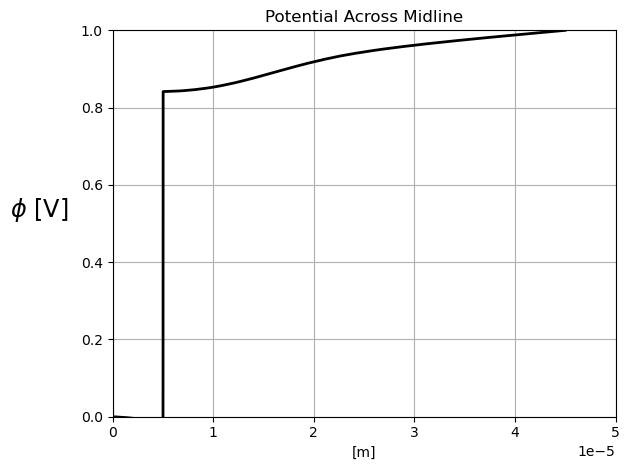

In [14]:
bb_trees = bb_tree(domain, domain.topology.dim)
n_points = 10000
tol = 1e-8  # Avoid hitting the outside of the domain

# midline in 2D
x = np.linspace(0 + tol, 45e-6 - tol, n_points)
y = np.ones(n_points) * 0.5 * 30e-6  # midline

points = np.zeros((3, n_points))
points[0] = x
points[1] = y

u_values = []
cells = []
points_on_proc = []
# Find cells whose bounding-box collide with the the points
cell_candidates = compute_collisions_points(bb_trees, points.T)
# Choose one of the cells that contains the point
colliding_cells = compute_colliding_cells(domain, cell_candidates, points.T)
for i, point in enumerate(points.T):
    if len(colliding_cells.links(i)) > 0:
        points_on_proc.append(point)
        cells.append(colliding_cells.links(i)[0])
points_on_proc = np.array(points_on_proc, dtype=np.float64)
u_values = u.eval(points_on_proc, cells)
fig, ax = plt.subplots()
ax.plot(points_on_proc[:, 0], u_values, "k", linewidth=2)
ax.grid(True)
ax.set_xlim([0, 50e-6])
ax.set_ylim([0, voltage])
ax.set_ylabel(r'$\phi$ [V]', rotation=0, labelpad=30, fontsize='xx-large')
ax.set_xlabel('[m]')
ax.set_title('Potential Across Midline')
plt.tight_layout()
plt.show()

## Concentration Problem

In [15]:
# full_mesh, cell_tags, facet_tags = dolfinx.io.gmshio.read_from_msh(output_meshfile, comm, 0)

# # Create submesh for pe
# pam_domain, entity_map, vertex_map, geom_map = dolfinx.mesh.create_submesh(full_mesh, full_mesh.topology.dim, cell_tags.indices[(cell_tags.values == mrkr.electrolyte)])

# # Transfer facet tags from parent mesh to submesh
# tdim = full_mesh.topology.dim
# fdim = tdim - 1
# c_to_f = full_mesh.topology.connectivity(tdim, fdim)
# f_map = full_mesh.topology.index_map(fdim)
# all_facets = f_map.size_local + f_map.num_ghosts
# all_values = np.zeros(all_facets, dtype=np.int32)
# all_values[facet_tags.indices] = facet_tags.values

# pam_domain.topology.create_entities(fdim)
# subf_map = pam_domain.topology.index_map(fdim)
# pam_domain.topology.create_connectivity(tdim, fdim)
# c_to_f_sub = pam_domain.topology.connectivity(tdim, fdim)
# num_sub_facets = subf_map.size_local + subf_map.num_ghosts
# sub_values = np.empty(num_sub_facets, dtype=np.int32)
# for i, entity in enumerate(entity_map):
#     parent_facets = c_to_f.links(entity)
#     child_facets = c_to_f_sub.links(i)
#     for child, parent in zip(child_facets, parent_facets):
#         sub_values[child] = all_values[parent]
# sub_meshtag = dolfinx.mesh.meshtags(pam_domain, pam_domain.topology.dim - 1, np.arange(
#     num_sub_facets, dtype=np.int32), sub_values)
# pam_domain.topology.create_connectivity(pam_domain.topology.dim - 1, pam_domain.topology.dim)

# with dolfinx.io.XDMFFile(comm, "submesh.xdmf", "w", encoding=encoding) as xdmf:
#     xdmf.write_mesh(pam_domain)
#     xdmf.write_meshtags(sub_meshtag, x=pam_domain.geometry)

In [16]:
# c_init = 1000  # mol/m3
# t = 0 # Start time
# eps = 1e-15
# dt = 1e-6
# T = 500 * dt

# dx = ufl.Measure("dx", domain=pam_domain)
# ds = ufl.Measure("ds", domain=pam_domain, subdomain_data=sub_meshtag)
# dS = ufl.Measure("dS", domain=pam_domain, subdomain_data=sub_meshtag)
# n = ufl.FacetNormal(pam_domain)
# tdim = pam_domain.topology.dim
# fdim = tdim - 1

# # Create boundary condition
# # boundary_facets = sub_meshtag.find(mrkr['middle'])
# # bc = fem.dirichletbc(PETSc.ScalarType(0), fem.locate_dofs_topological(Q, fdim, boundary_facets), Q)

# Q = fem.FunctionSpace(pam_domain, ("CG", 1))
# c_n = fem.Function(Q)
# c_n.name = "c_n"
# c_n.interpolate(lambda x:  x[0] - x[0] + c_init)
# c_n.x.scatter_forward()

# potential = fem.Function(Q)
# padding = 1e-16
# u1_2_u2_nmm_data = \
#         fem.create_nonmatching_meshes_interpolation_data(
#             potential.function_space.mesh._cpp_object,
#             potential.function_space.element,
#             u_cg.function_space.mesh._cpp_object, padding=padding)

# potential.interpolate(u, nmm_interpolation_data=u1_2_u2_nmm_data)
# potential.x.scatter_forward()

# ch = fem.Function(Q)
# ch.name = "concentration"
# ch.interpolate(lambda x: x[0] - x[0] + c_init)
# ch.x.scatter_forward()

# c = ufl.TrialFunction(Q)
# q = ufl.TestFunction(Q)

# f = fem.Constant(pam_domain, PETSc.ScalarType(0))
# g = fem.Constant(pam_domain, PETSc.ScalarType(0))
# g_middle = fem.Constant(pam_domain, PETSc.ScalarType(0))
# D_bulk = 1e-2
# D = fem.Constant(pam_domain, PETSc.ScalarType(D_bulk))

# a = c * q * dx + dt * ufl.inner(D * ufl.grad(c), ufl.grad(q)) * dx
# L = (
#     (c_n + dt * f) * q * dx 
#     + dt * ufl.inner(g, q) * ds(mrkr.insulated_electrolyte) 
#     + dt * ufl.inner(g, q) * ds(mrkr.right)
#     + dt * ufl.inner(ufl.grad(potential) / 96485, n) * q * ds(mrkr.middle)
# )

# bilinear_form = fem.form(a)
# linear_form = fem.form(L)

# A = petsc.assemble_matrix(bilinear_form, bcs=[])
# A.assemble()
# b = fem.petsc.create_vector(linear_form)

# solver = PETSc.KSP().create(comm)
# solver.setOperators(A)
# solver.setType(PETSc.KSP.Type.PREONLY)
# solver.getPC().setType(PETSc.PC.Type.LU)

# c_vtx = VTXWriter(comm, concentration_resultsfile, [ch], engine="BP4")
# c_vtx.write(0.0)

# while t < T:
#     t += dt

#     A = fem.petsc.assemble_matrix(bilinear_form, bcs=[])
#     A.assemble()
#     solver.setOperators(A)

#     # Update the right hand side reusing the initial vector
#     with b.localForm() as loc_b:
#         loc_b.set(0)
#     fem.petsc.assemble_vector(b, linear_form)

#     # Apply Dirichlet boundary condition to the vector
#     fem.petsc.apply_lifting(b, [bilinear_form], [[]])
#     b.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
#     fem.petsc.set_bc(b, [])

#     # Solve linear problem
#     solver.solve(b, ch.vector)
#     ch.x.scatter_forward()
#     # c_avg = fem.assemble_scalar(fem.form(ch * dx)) / fem.assemble_scalar(fem.form(1 * dx))
#     # print(f"average concentration: {c_avg}")

#     # Update solution at previous time step (c_n)
#     if np.any(ch.x.array < 0):
#         print(f"Lithium depletion at {t:.2e} seconds")
#         break
#     if np.any(ch.x.array == np.inf):
#         print(f"diverged at {t:.2e} seconds")
#         break
#     c_n.x.array[:] = ch.x.array
#     c_vtx.write(t)
# c_vtx.close()

In [17]:
# visualization
# bb_trees = bb_tree(pam_domain, pam_domain.topology.dim)
# n_points = 10000
# tol = 1e-8  # Avoid hitting the outside of the domain

# # midline in 2D
# x = np.linspace(0 + tol, 45e-6 - tol, n_points)
# y = np.ones(n_points) * 0.5 * 30e-6  # midline

# points = np.zeros((3, n_points))
# points[0] = x
# points[1] = y
# u_values = []
# cells = []
# points_on_proc = []
# # Find cells whose bounding-box collide with the the points
# cell_candidates = compute_collisions_points(bb_trees, points.T)
# # Choose one of the cells that contains the point
# colliding_cells = compute_colliding_cells(pam_domain, cell_candidates, points.T)
# for i, point in enumerate(points.T):
#     if len(colliding_cells.links(i)) > 0:
#         points_on_proc.append(point)
#         cells.append(colliding_cells.links(i)[0])
# points_on_proc = np.array(points_on_proc, dtype=np.float64)
# u_values = ch.eval(points_on_proc, cells)
# fig, ax = plt.subplots()
# ax.plot(points_on_proc[:, 0], u_values, "k", linewidth=2)
# ax.grid(True)
# ax.set_xlim([0, 45e-6])
# # ax.set_ylim([0, c_init])
# ax.set_ylabel(r'$c$ [mol/m$^3$]', rotation=0, labelpad=50, fontsize='xx-large');
# ax.set_xlabel('[m]');
# ax.set_title(f't = {t:.1e} s, and D = {D_bulk:.1e} ' + r'm$^{2}$s$^{-1}$');
# plt.tight_layout();
# plt.savefig(f'figures/lma-concentration-{D_bulk:.2e}.png', dpi=1500);